In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, Callable, Union, Optional
from tensor_type import Tensor
from scipy.stats import norm, expon, uniform, multivariate_normal
from torch import mm, exp, log, det, minimum, sqrt, mul
from torch.linalg import inv, det

import time
import pdb

In [2]:
def KE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor]=None,
       detM: Optional[float] =0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        ke = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        ke = .5 * mm(a.t(),a)
    return ke

def PE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor] = None,
       detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        pe = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        pe = .5 * mm(a.t(),a)
    return pe

In [3]:
def get_autograd(func: Callable,
                 x:    Tensor,
                 mu:   Tensor,
                 Mat:  Tensor,
                 detMat: Optional[float] =0.0) -> Tuple[Tensor, Tensor]:
    '''
    dH calculates K(p) or V(q) along with associated gradient.
    x: is a tensor
    Mat: is a mass matrix
    func: is the K or V function to calculate
    returns function output and gradient
    '''
    #pdb.set_trace()
    x.requires_grad_(True) # track math operations
    x.retain_grad() # keep gradient after backward()
    out = func(x, mu, Mat, detMat)  # calculate given function
    out.backward(gradient=torch.ones(out.size()))  # Calculate grads
    x_grad = x.grad.data  # get gradients only
    x.grad = None  # reset gradient 
    x.requires_grad_(False)  # stop tracking
    return out.detach().clone(), x_grad 

# Unit Test
#t = torch.tensor([6., 4.]).view(2,1)
#tout, dt = dH(t, Minv, Tst2)

In [4]:
def stormer_verlet(V:    Callable,
                   q0:   Tensor,
                   p0:   Tensor,
                   mu:   Tensor,
                   Minv: Tensor,
                   eps:  float,
                   T:    int) -> Tuple[Tensor, Tensor]:
    '''
    Stormer-Verlet should propagate a point in phase space
    (p,q) according to Hamiltonian H.
    
    dVdq: references a function yielding the derivative of
    potential energy V.
    q0: is initial position tensor
    p0: is initial momentum tensor
    epsilon: scalar time increment
    T: time interval length
    returns numpy arrays q and p
    '''
    global qPath
    Nsteps = int(T//eps)
    q, p = q0.clone(), p0.clone()    
    for n in range(Nsteps):
        #pdb.set_trace()
        start = time.time()
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        d1 = time.time()-start
        
        p -= eps * dHdq/2 # half momentum step
        q += eps * p # full parameter step
        
        start = time.time()
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        d2 = time.time()-start
        p -= eps * dHdq # full momentum step
        
        qPath[n,:] = torch.squeeze(q)
        #print(f'n={n}  derivative time {d1:.6f} --- {d2:.6f}')
        
    return q,-p 

In [5]:
def acceptance(q0: Tensor,
               p0: Tensor,
               q:  Tensor,
               p:  Tensor,
               mu: Tensor,
               Minv: Optional[Tensor]=None) -> Tuple[Tensor, bool]:
    #pdb.set_trace()
    KE0, PE0       = KE(q0, mu, Minv, detM) , PE(p0, mu, Minv, detM) 
    KEstar, PEstar = KE(q, mu, Minv, detM)  , PE(p, mu, Minv, detM)
    ke_diff = exp((KE0 + PE0) - (KEstar + PEstar)).item()
    r = min(1., ke_diff)
    obs = uniform.rvs()
    if obs < r:
        point = q
        acceptFlag = True
    else:
        point = q0
        acceptFlag = False
    return point, acceptFlag

In [6]:
T = 3  # Full time-steps
eps = 0.2  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 2000  # Number of q's to test 
D = 2  # Dimension of q
M = torch.tensor([[1., 0.8],
                  [0.8, 1.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.],[0.]],dtype=torch.float32)

In [7]:
%%time
accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic
allPaths = qPath = torch.zeros((Nq, Nsteps, D))
pathFlag = []

# pre-select random q's
Q0 = np.random.uniform(low=-4, high=4, size=(D,Nq)) #(2,100)
# Loop iterations
for n in range(Nq):
    #print(f'Iter: {n}')
    qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0[:,n].reshape(2,1)).type(torch.float32)
    # sample momentum p0 from normal
    p0 = torch.from_numpy(norm.rvs(size = 2)).type(torch.float32).view(2,1)
    #print(p0.size())
    # q0,p0 are (2,1) tensors
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    pathFlag.append(aFlag)
    allPaths[n,:,:] = qPath[:,:]
    
print(f'Acceptance rate: {accepted/Nq}')    
print(acceptedPoints.size())

Acceptance rate: 0.1465
torch.Size([2, 2000])
CPU times: user 11.9 s, sys: 73.3 ms, total: 12 s
Wall time: 11.8 s


In [8]:
acceptedPoints_np = acceptedPoints.numpy()
allPaths_np = allPaths.numpy()
allPaths_np.shape

(2000, 14, 2)

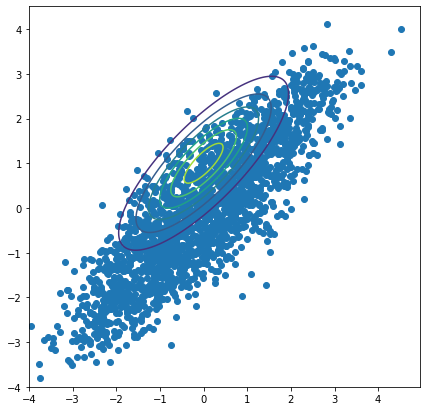

In [9]:
N    = 200
X    = np.linspace(-4, 4, N)
Y    = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv   = multivariate_normal([0, 1], [[1., 0.8],[0.8, 1.]])
Z    = rv.pdf(pos)

plt.figure(figsize=(7,7))
plt.contour(X, Y, Z)
#for i in range(30):
#    if(pathFlag[i]):
#        plt.plot(allPaths_np[i,-1,0], allPaths_np[i,-1,1], 'b-')
#    else:
#        pass
        #plt.plot(allPaths_np[i,:,0], allPaths_np[i,:,1], 'r-')
plt.scatter(acceptedPoints_np[0,:], acceptedPoints_np[1,:])
plt.show()